pake dataset dari tmn mama / om axcel

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [37]:
file_path = r"C:\Users\HP\Documents\data mining\XAUUSD H1.csv"
data = pd.read_csv(file_path)

# Display basic info and the first few rows to understand its structure and confirm columns
data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83892 entries, 0 to 83891
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   2010.01.03  82003 non-null  object 
 1   23:00       82003 non-null  object 
 2   1097.45     82003 non-null  float64
 3   1100.6      82003 non-null  float64
 4   1095.57     82003 non-null  float64
 5   1095.57.1   82003 non-null  float64
 6   3635        82003 non-null  float64
dtypes: float64(5), object(2)
memory usage: 4.5+ MB


(None,
    2010.01.03 23:00  1097.45   1100.6  1095.57  1095.57.1    3635
 0  2010.01.04  0:00  1096.00  1096.90  1093.08    1094.49  3765.0
 1  2010.01.04  1:00  1094.95  1095.95  1094.00    1095.65  3017.0
 2  2010.01.04  2:00  1095.35  1099.15  1095.28    1097.87  3242.0
 3  2010.01.04  3:00  1097.87  1099.64  1096.95    1098.89  2676.0
 4  2010.01.04  4:00  1098.86  1102.75  1098.52    1101.60  2954.0)

In [38]:
# Bersihkan dan proses data
data.columns = ['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data = data[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.set_index('Datetime', inplace=True)
data.dropna(inplace=True)

In [39]:
# data['Close'] = pd.to_numeric(data['Close'], errors='coerce')  # Pastikan kolom Close numeric


perbaikan

In [40]:
# Extract closing prices
prices = data['Close'].values.reshape(-1, 1)


In [41]:
# Ambil hanya harga Close untuk prediksi
# skala data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(prices)


perbaikan

In [42]:
# Hyperparameters
sequence_length = 50
lstm_units = 64
dropout_rate = 0.3
epochs = 100
batch_size = 32
learning_rate = 0.0001

In [43]:
# buat sequence
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, 0])  # Ambil sequence_length data sebelumnya
        y.append(data[i, 0])  # Data target
    return np.array(x), np.array(y)

# Panjang urutan
x, y = create_sequences(data_scaled, sequence_length)


In [44]:
# Bagi data menjadi pelatihan dan pengujian
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [45]:
# Ubah bentuk data
x_train = np.expand_dims(x_train, axis=-1)  # Tambahkan dimensi fitur
x_test = np.expand_dims(x_test, axis=-1)


perbaikan

In [46]:

# # Menambahkan Batch Normalization
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True),
#     BatchNormalization(),
#     Dropout(0.3),
#     LSTM(lstm_units, return_sequences=False),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(25),
#     Dense(1)
# ])


perbaikan

In [47]:

# # Menggunakan regularisasi L2 pada LSTM layers
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
#     Dropout(0.3),
#     LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
#     Dropout(0.3),
#     Dense(25),
#     Dense(1)
# ])


perbaikan

In [48]:
# Buat model dgn beberapa teknik regularisasi 
input_shape = (sequence_length, x_train.shape[-1])
# model = Sequential([
#     Input(shape=(sequence_length, 1)),
#     LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
#     BatchNormalization(),
#     Dropout(dropout_rate),
#     LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
#     BatchNormalization(),
#     Dropout(dropout_rate),
#     Dense(25),
#     Dense(1)
# ])

model = Sequential([
    Input(shape=input_shape),
    LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(dropout_rate),
    LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(25, activation='relu'),
    Dense(1)
])


optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')


In [49]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [50]:
# Latih model
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100


2049/2049 ━━━━━━━━━━━━━━━━━━━━ 161s 71ms/step - loss: 0.4541 - val_loss: 0.0929
Epoch 2/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 204s 72ms/step - loss: 0.1209 - val_loss: 0.0619
Epoch 3/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 150s 73ms/step - loss: 0.0685 - val_loss: 0.0350
Epoch 4/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 200s 72ms/step - loss: 0.0349 - val_loss: 0.0151
Epoch 5/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 200s 71ms/step - loss: 0.0159 - val_loss: 0.0066
Epoch 6/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 203s 72ms/step - loss: 0.0077 - val_loss: 0.0053
Epoch 7/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 211s 76ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 8/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 148s 72ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 9/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 152s 74ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 10/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 205s 76ms/step - loss: 0.0014 - val_loss: 5.0431e-04
Epoch 11/100
2049/2049 ━━━━━━━━━━━━━━━━━━━━ 196s 73ms/step - loss: 0.0012 - val_loss: 4

perbaikan

In [51]:
# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")


513/513 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.0264e-04
Test Loss: 0.00010751644003903493


In [52]:
# Prediksi
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


513/513 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step


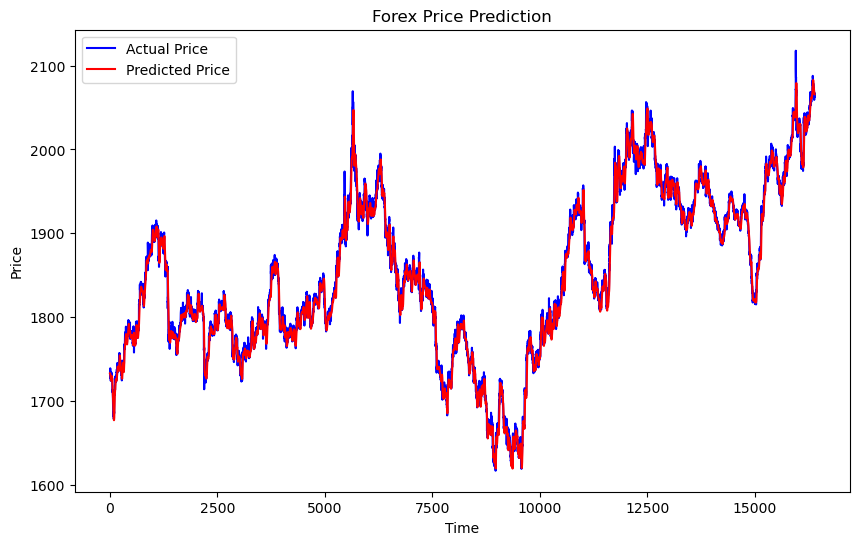

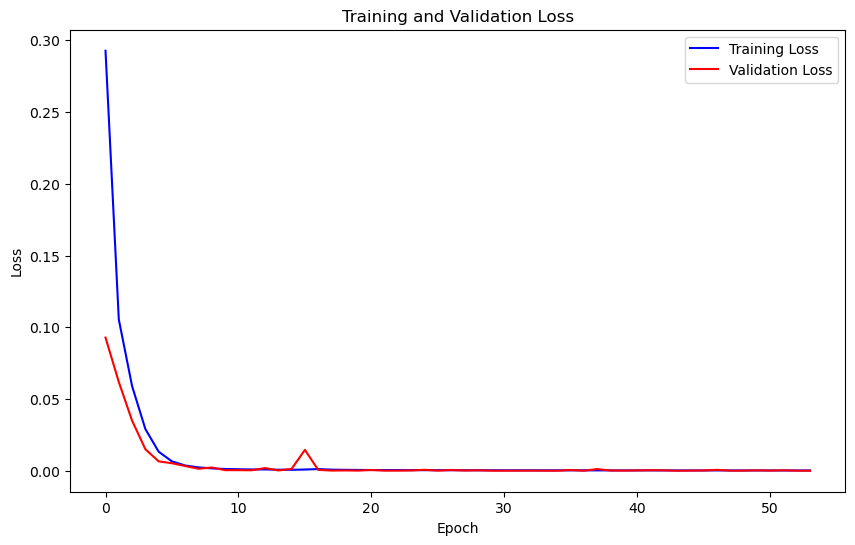

In [53]:
# Evaluasi
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label="Actual Price", color="blue")
plt.plot(predictions, label="Predicted Price", color="red")
plt.title("Forex Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


tambahan

In [54]:

# Hitung metrik evaluasi
mse = mean_squared_error(y_test_scaled, predictions)
mae = mean_absolute_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


Mean Squared Error (MSE): 70.57650676632376
Mean Absolute Error (MAE): 6.012194804110773
R-squared (R²): 0.9925877986497064


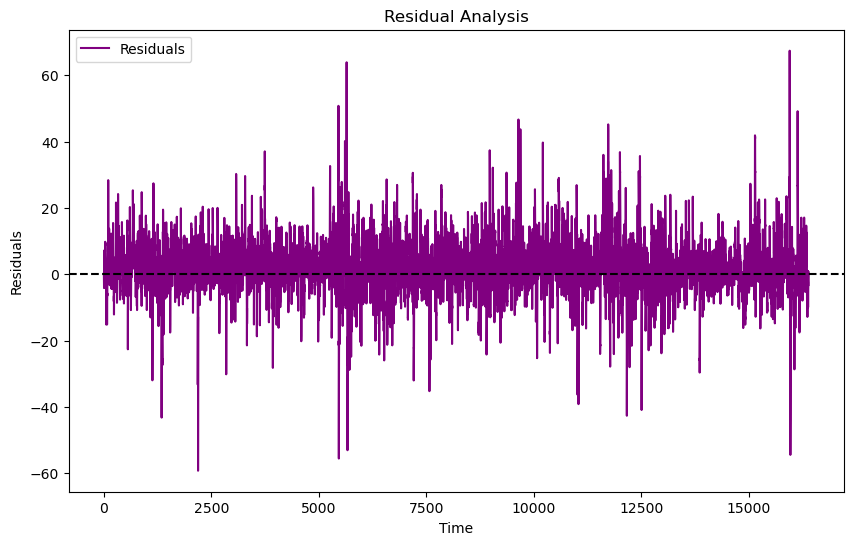

In [55]:
residuals = y_test_scaled - predictions
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residual Analysis')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [56]:
# Moving Average
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()


In [57]:
# Moving Average Convergence Divergence (MACD)
short_window = 12
long_window = 26
signal_window = 9

data['EMA_12'] = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=signal_window, min_periods=1, adjust=False).mean()


In [58]:
# Rate of Change (ROC)
data['ROC_10'] = ((data['Close'] - data['Close'].shift(10)) / data['Close'].shift(10)) * 100


In [59]:
# Momentum
data['Momentum'] = data['Close'] - data['Close'].shift(10)


In [60]:
# Relative Strength Index (RSI)
def calculate_RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

data['RSI_14'] = calculate_RSI(data)


In [61]:
# Bollinger Bands (BB)
window = 20
data['BB_Middle'] = data['Close'].rolling(window=window).mean()
data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(window=window).std()
data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(window=window).std()


In [62]:
# Commodity Channel Index (CCI)
def calculate_CCI(data, window=20):
    TP = (data['High'] + data['Low'] + data['Close']) / 3
    rolling_mean_TP = TP.rolling(window=window).mean()
    rolling_std_TP = TP.rolling(window=window).std()
    
    CCI = (TP - rolling_mean_TP) / (0.015 * rolling_std_TP)
    return CCI

data['CCI_20'] = calculate_CCI(data)


In [63]:
# Drop NaN values after calculation
data.dropna(inplace=True)


In [64]:
# Display the dataset with indicators
print(data.head())


                        Open     High      Low    Close  Volume     MA_10  \
Datetime                                                                    
2010-01-06 01:00:00  1118.50  1122.05  1118.50  1122.05   677.0  1119.595   
2010-01-06 02:00:00  1122.15  1124.00  1120.95  1123.95   524.0  1119.615   
2010-01-06 03:00:00  1124.00  1124.80  1122.35  1123.00   507.0  1119.775   
2010-01-06 04:00:00  1123.00  1124.95  1122.90  1122.95   540.0  1120.320   
2010-01-06 05:00:00  1122.90  1124.40  1122.15  1122.90   603.0  1120.790   

                         MA_50       EMA_12       EMA_26      MACD  \
Datetime                                                             
2010-01-06 01:00:00  1117.0836  1120.184747  1119.869214  0.315534   
2010-01-06 02:00:00  1117.6728  1120.764017  1120.171494  0.592523   
2010-01-06 03:00:00  1118.2198  1121.108014  1120.381013  0.727001   
2010-01-06 04:00:00  1118.7214  1121.391397  1120.571308  0.820088   
2010-01-06 05:00:00  1119.2016  1121.623

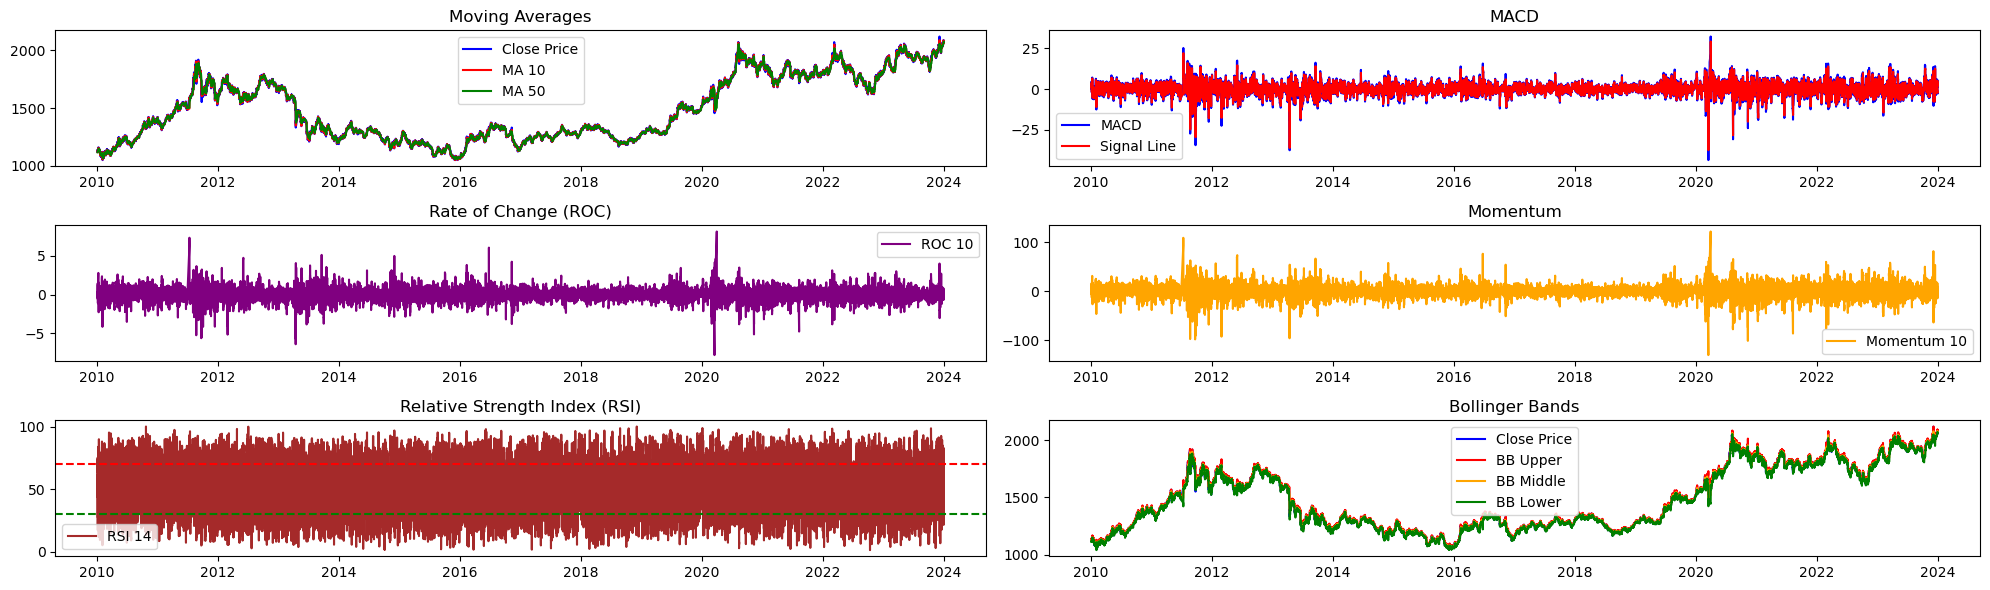

In [78]:
# Plot the indicators
plt.figure(figsize=(20, 6))

# Plot MA
plt.subplot(3, 2, 1)
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA_10'], label='MA 10', color='red')
plt.plot(data['MA_50'], label='MA 50', color='green')
plt.title('Moving Averages')
plt.legend()

# Plot MACD
plt.subplot(3, 2, 2)
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal_Line'], label='Signal Line', color='red')
plt.title('MACD')
plt.legend()

# Plot ROC
plt.subplot(3, 2, 3)
plt.plot(data['ROC_10'], label='ROC 10', color='purple')
plt.title('Rate of Change (ROC)')
plt.legend()

# Plot Momentum
plt.subplot(3, 2, 4)
plt.plot(data['Momentum'], label='Momentum 10', color='orange')
plt.title('Momentum')
plt.legend()

# Plot RSI
plt.subplot(3, 2, 5)
plt.plot(data['RSI_14'], label='RSI 14', color='brown')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.title('Relative Strength Index (RSI)')
plt.legend()

# Plot Bollinger Bands
plt.subplot(3, 2, 6)
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['BB_Upper'], label='BB Upper', color='red')
plt.plot(data['BB_Middle'], label='BB Middle', color='orange')
plt.plot(data['BB_Lower'], label='BB Lower', color='green')
plt.title('Bollinger Bands')
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
last_sequence = data_scaled[-sequence_length:]  # Ambil window terakhir
last_sequence = np.expand_dims(last_sequence, axis=0)  # Ubah bentuk
future_prediction = model.predict(last_sequence)
future_prediction = scaler.inverse_transform(future_prediction)
print("Prediksi Harga Masa Depan:", future_prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Prediksi Harga Masa Depan: [[2065.546]]


In [77]:
# Simpan model
model.save('my_model.keras')
